# Variational Quantum Linear Solver for the Euler Beam Theory

The steady state beam equation for a simply supported beam is given by:
\begin{equation}
\frac{d^4 w}{dx^4} = \frac{q(x)}{EI}
\end{equation}
with Dirichlet Boundary Conditions $w(0) = w(L) = 0$


## Library Imports

In [1]:
# Import the necessary libraries
import qiskit
from qiskit import *
from qiskit_aer.noise import NoiseModel
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pylatexenc
from scipy.optimize import minimize
from qiskit.extensions import *
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
import math
import cmath
import random
import timeit

## Generate Right Hand Side

For the discretized right hand side, we get a vector:
\begin{equation}
\vec{f} = -\frac{q\Delta x^4}{EI}[1,1,.....,1]^T
\end{equation}

In [2]:
# f = [1,1,1,1,1,1,1,1]^T with two additional boundary points (u(0) and u(1))
def create_b(circuit,qubits):
    for i in qubits:
        circuit.h(i)

def create_b_dagger(circuit, qubits):
    create_b(circuit,qubits)

## Generate Ansatz for VQLS

We opt for the Fixed Hardware (Hardware Efficient) Ansatz which consists of $R_y$ and $C_z$ gates for rotation and entanglement as shown in the figure below (for the 2 qubit system).

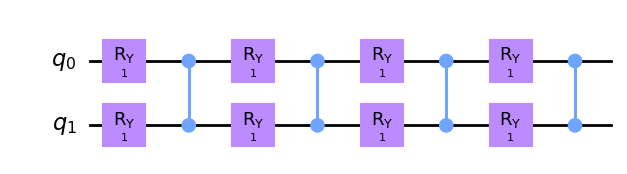

In [3]:
ansatz_param = None

def create_ansatz(circuit, qubit_list, layers):
    param_idx = 0
    for i in range(len(qubit_list)):
        circuit.ry(ansatz_param[param_idx], qubit_list[i])
        param_idx += 1
    for k in range(layers):
        circuit.cz(qubit_list[0], qubit_list[1])
        for i in range(len(qubit_list)):
            circuit.ry(ansatz_param[param_idx], qubit_list[i])
            param_idx += 1

In [4]:
def get_submatrix(elm):
    matrix_list = []
    for k in range(len(elm)):
        if elm[k] == 'I':
            mat = I
        elif elm[k] == 'X':
            mat = X
        elif elm[k] == 'Y':
            mat = Y
        else:
            mat = Z
        matrix_list.append(mat)
    sub_matrix = np.kron(matrix_list[0], matrix_list[1])
    return sub_matrix
    

c = []

I = np.eye(2)
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])

matrix_array = ['II','IX','XX','YY',"XI", 'ZZ']

A = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        if i == j:
            A[i,j] = 6
        elif i == j+1 or i == j-1:
            A[i,j] = -4
        elif i == j+2 or i == j-2:
            A[i,j] = -1
        else:
            pass

A[0,0] = 5
A[3,3] = 5

# To find the co-efficient list
for element in matrix_array:
    Al = get_submatrix(element)
    coef = (1/4) * np.trace(Al @ A)
    c.append(coef)

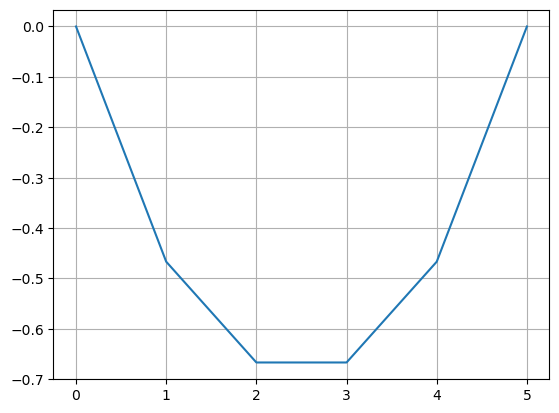

In [5]:
b = np.ones(4)
w = np.linalg.solve(A,b)
sol = np.zeros(6)
for i in range(4):
    sol[i+1] = w[i]
plt.plot(sol)
plt.grid()
plt.show()

## Generate Input Matrix

The input matrix from the Finite Difference Method Approximation can be decomposed as follows:
\begin{equation}
A = 5.5I_1I_2 - 4I_1X_2 - 2X_1X_2 - 2Y_1Y_2 - X_1I_2 - 0.5Z_1Z_2
\end{equation}

In [6]:
c = [5.5, -4, -2, -2, -1, -0.5]
#c = [6,-4,-2,-2,-1]

def create_A(circuit, idx):
    if idx == 0:
        None
    elif idx == 1:
        circuit.cx(0,2)
    elif idx == 2:
        circuit.cx(0,1)
        circuit.cx(0,2)
    elif idx == 3:
        circuit.cy(0,1)
        circuit.cy(0,2)
    elif idx == 4:
        circuit.cx(0,1)
    elif idx == 5:
        circuit.cz(0,1)
        circuit.cz(0,2)
    else:
        None

def create_A_dagger(circuit, idx):
    create_A(circuit, idx)

## Create the Cost Function

Here, we go with the method of local cost functions:
\begin{equation}
C_L = \langle \psi|H_L|\psi\rangle
\end{equation}
This is done by computing the local Hamiltonians for each combination of the polynomial decomposition of the matrix A, as given by:
\begin{equation}
C_L = \frac{1}{2} - \frac{1}{2n}\frac{\sum_{l=0}^{m}\sum_{lp=0}^{m}\langle b|A_lA_{lp}^{\dagger}|\psi\rangle}{\sum_{l=0}^{m}\sum_{lp=0}^{m}\langle\psi|A_lA_{lp}^{\dagger}|\psi\rangle}
\end{equation}
where $n$ is the number of qubits required to approximate the solution.

In [7]:
IBMQ.save_account('78abd9fcf5ff27eaf589d56f4aa4a338b9eb64c200d204714f0912d913d4965489c71e8136a652820073db07642cd3788aa6e2ef2c3030639dc90bd12e6ad334')

/tmp/ipykernel_30121/2425059977.py:1: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.save_account('78abd9fcf5ff27eaf589d56f4aa4a338b9eb64c200d204714f0912d913d4965489c71e8136a652820073db07642cd3788aa6e2ef2c3030639dc90bd12e6ad334')
/tmp/ipykernel_30121/2425059977.py:1: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.save_account('78abd9fcf5ff27eaf589d56f4aa4a338b9

In [11]:
# Specify parameters
shots = 20000
#noise_model = None
provider = IBMQ.load_account()
backend = provider.get_backend('ibm_osaka')
noise_model = NoiseModel.from_backend(backend)
n_qubit = np.log2(len(b))
n_qubit = int(n_qubit)
backend = Aer.get_backend('qasm_simulator')

# Create the function to evaluate the denominator of the Hadamard Test
def denom_Hadamard(l,lp,part='Re'):
    quantum_circuit = QuantumCircuit(n_qubit+1,1)
    quantum_circuit.h(0)
    
    if part == 'Im':
        quantum_circuit.sdg(0)
    
    create_ansatz(quantum_circuit, [i+1 for i in range(n_qubit)], layer)
    create_A(quantum_circuit,l)
    create_A_dagger(quantum_circuit,lp)

    quantum_circuit.h(0)
    quantum_circuit.measure(0,0)

    job = execute(quantum_circuit, backend=backend, shots=shots, noise_model=noise_model)
    result = job.result().get_counts()

    try:
        P0 = result["0"]
        P1 = shots - P0
    except:
        P1 = shots
        P0 = 0
    
    beta_denom = (P0 - P1)/shots
    return beta_denom

# Create the function to evaluate the numerator of the Hadamard Test
def numer_Hadamard(l,lp,j,part="Re"):
    quantum_circuit = QuantumCircuit(n_qubit+1,1)
    quantum_circuit.h(0)

    if part == "Im":
        quantum_circuit.sdg(0)
    
    create_ansatz(quantum_circuit, [i+1 for i in range(n_qubit)], layer)
    create_A(quantum_circuit, l)
    create_b_dagger(quantum_circuit, [i+1 for i in range(n_qubit)])
    quantum_circuit.cz(0,j)
    create_b(quantum_circuit, [i+1 for i in range(n_qubit)])
    create_A_dagger(quantum_circuit, lp)

    quantum_circuit.h(0)
    quantum_circuit.measure(0,0)

    job = execute(quantum_circuit,backend=backend, shots=shots, noise_model=noise_model)
    result = job.result().get_counts()

    try:
        P0 = result["0"]
        P1 = shots - P0
    except:
        P1 = shots
        P0 = 0
    
    delta_num = (P0 - P1)/shots
    return delta_num

# Create the function for the classical evaluation of the cost function
def cost_function(ansatz_param_updated):
    global ansatz_param, iteration

    ansatz_param = ansatz_param_updated
    num_sum = 0
    denom_sum = 0
    
    #start = time.time()

    for l in range(len(c)):
        for lp in range(len(c)):
            denom_sum += (c[l] * np.conj(c[lp]) * denom_Hadamard(l,lp,"Re"))
            for j in range(1,n_qubit+1):
                num_sum += (c[l] * np.conj(c[lp]) * numer_Hadamard(l,lp,j,"Re"))
    
    x = 0.5 - 0.5*num_sum/(n_qubit * denom_sum)
    #x = 1 - num_sum*num_sum/denom_sum
    x = abs(x)
    
    #end = time.time()
    
    #print(f'Iteration: {iteration}\tCost Function: {x}\tExecution Time: {end - start}')
    #time_list.append(end - start)
    print(f'Iteration: {iteration}\tCost Function: {x}')
    cost_list.append(x)
    iteration += 1
    return x

ibmqfactory.load_account:WARNING:2024-01-19 14:46:00,374: Credentials are already in use. The existing account in the session will be replaced.


In [12]:
layer = 16
parameter_number = layer*n_qubit + 2
theta0 = np.random.normal(0, np.pi/2, parameter_number)
#theta0 = [random.random()*2*np.pi for i in range(layer*n_qubit + 2)]
cost_list = []
iteration = 1
minimize(cost_function, x0=theta0, args=(), method='COBYLA', tol=1e-4, options={'maxiter':1000, 'rhobeg':np.pi/4})

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

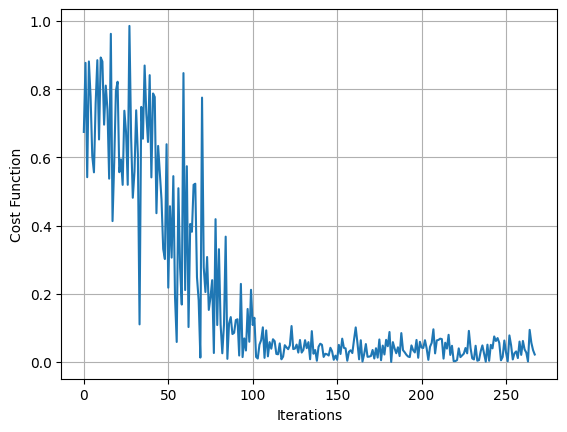

In [12]:
#np.savetxt('Opt_Parameters_Euler.txt', ansatz_param)
plt.plot(cost_list)
plt.xlabel('Iterations')
plt.ylabel('Cost Function')
plt.grid()
plt.show()

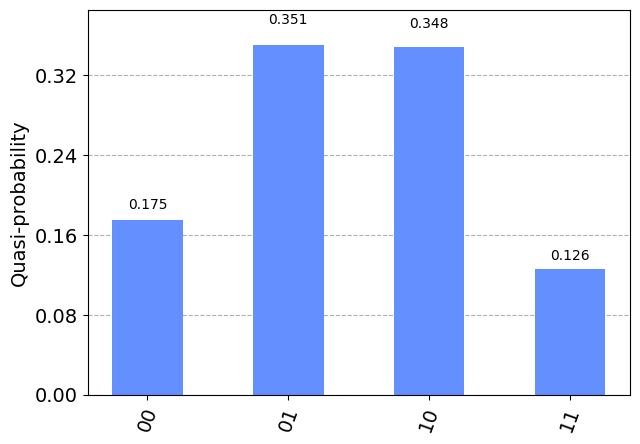

In [13]:
qc_final = QuantumCircuit(n_qubit)
create_ansatz(qc_final, [0,1], layer)
qc_final.measure_all()
job = execute(qc_final, backend=backend, shots=100*shots, noise_model=noise_model)
results = job.result().get_counts()
for key in results:
    results[key] *= (0.01/shots)
plot_histogram(results)

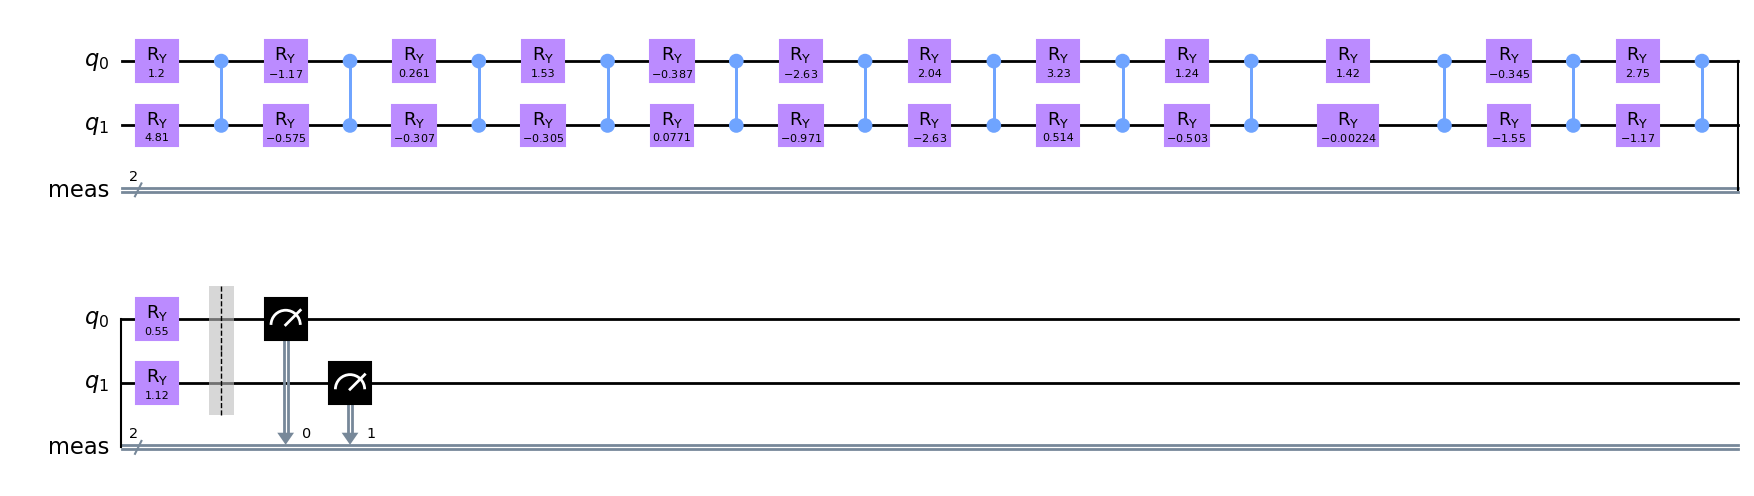

In [14]:
qc_final.draw('mpl')